In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install rasterio
!pip install nvector

In [0]:
# See https://stackoverflow.com/questions/55821982/is-there-a-way-to-import-future-in-colaboratory
# from __future__ import annotations
import numpy as np
import rasterio
import nvector as nv
import matplotlib.pyplot as plt
import json
from typing import Tuple, List, Dict
from tqdm import tqdm
from numba import jit, cuda 
%matplotlib inline


# Calculate tops of the world in Google Colab

In [0]:
class LatLongElev:
    def __init__(self, latitude: float, longitude: float, elevation: float=0.0):
        self.latitude = latitude
        self.longitude = longitude
        self.elevation = elevation


class XYZ:
    def __init__(self, x: float, y: float, z: float):
        self.x = x
        self.y = y
        self.z = z

    def __eq__(self, xyz) -> bool:
        return self.x == xyz.x and self.y == xyz.y and self.z == xyz.z

    def __str__(self) -> str:
        return "x={}, y={}, z={}".format(self.x, self.y, self.z)

    def __hash__(self) -> int:
        return hash((self.x, self.y, self.z))

    def project_onto_line(self, _a, _b):
        # See https://gamedev.stackexchange.com/questions/72528/how-can-i-project-a-3d-point-onto-a-3d-line
        p = self.to_np_array()
        a = _a.to_np_array()
        b = _b.to_np_array()
        ap = p-a
        ab = b-a
        result = a + np.dot(ap, ab)/np.dot(ab, ab) * ab
        return XYZ(result[0], result[1], result[2])

    def get_chunk_index(self, chunk_size: float):
        x = self.x - self.x % chunk_size
        y = self.y - self.y % chunk_size
        z = self.z - self.z % chunk_size
        return XYZ(x, y, z)

    def to_np_array(self) -> np.array:
        return np.array([self.x, self.y, self.z])

In [0]:
def plotGlobe(xyz_list: List[XYZ]):
    x = [xyz.x for xyz in xyz_list]
    y = [xyz.y for xyz in xyz_list]
    z = [xyz.z for xyz in xyz_list]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()


DEEPEST_DEPRESSION_ON_EARTH = -418.0
def get_latlongelev_list_from_tif_image(image_file: str, step: int=1) -> List[LatLongElev]:
    latlongelev_list = []
    with rasterio.open(image_file) as image:
        elevation_values = image.read(1)
        for y in range(0, image.height, step):
            for x in range(0, image.width, step):
                longitude, latitude = image.xy(y, x)
                elevation = elevation_values[y, x]
                # Clean under the sea elevations
                elevation = elevation if elevation > DEEPEST_DEPRESSION_ON_EARTH else DEEPEST_DEPRESSION_ON_EARTH
                latlongelev_list.append(LatLongElev(latitude, longitude, elevation))
    return latlongelev_list


@jit(forceobj=True)
def latlongelev_list_to_xyz_list(latlongelev_list: List[LatLongElev]) -> List[XYZ]:
    # See https://github.com/pbrod/nvector#example-4-geodetic-latitude-to-ecef-vector
    wgs84 = nv.FrameE(name='WGS84')
    xyz_list = []
    for latlongelev in latlongelev_list:
        depth = latlongelev.elevation * (-1)
        pointB = wgs84.GeoPoint(latitude=latlongelev.latitude, longitude=latlongelev.longitude, z=depth, degrees=True)
        p_EB_E = pointB.to_ecef_vector()
        x, y, z = p_EB_E.pvector.ravel()[0], p_EB_E.pvector.ravel()[1], p_EB_E.pvector.ravel()[2]
        xyz_list.append(XYZ(x, y, z))
    return xyz_list


@jit(forceobj=True)
def filter_only_tops(xyz_list: List[XYZ]) -> List[XYZ]:
    progress_bar = tqdm(total=len(xyz_list))
    top_list = []
    for xyz in xyz_list:
        top = get_top_for_direction(xyz, xyz_list)
        # Store only unique tops
        if top not in top_list: 
            top_list.append(top)
        progress_bar.update(1)
    progress_bar.close()
    return top_list


CENTER_OF_THE_EARTH = XYZ(0, 0, 0)
@jit(forceobj=True)
def get_top_for_direction(direction: XYZ, xyz_list) -> XYZ:
    xyz_projection_list = []
    for xyz in xyz_list:
        xyz_projection = xyz.project_onto_line(CENTER_OF_THE_EARTH, direction)
        if are_on_the_same_side_relative_to_center(xyz_projection, direction):
            xyz_projection_list.append((xyz, xyz_projection))

    # Lambda cannot be passed as an argument while using JIT
    # See https://github.com/numba/numba/issues/4481#issuecomment-524914268
    top = max(xyz_projection_list, key=_distance_wrapper)[0]
    return top


def are_on_the_same_side_relative_to_center(a: XYZ, b: XYZ) -> bool:
    signs = np.sign([a.x, b.x, a.y, b.y, a.z, b.z])
    for axis in range(0, 6, 2):
        if signs[0+axis] != signs[1+axis]:
            return False
    return True


def _distance_wrapper(xyz_tuple: Tuple[XYZ, XYZ]) -> float:
    return _distance(xyz_tuple[1])


def _distance(xyz: XYZ) -> float:
    # The square root function is monotonic, so it can be discarded
    return xyz.x**2 + xyz.y**2 + xyz.z**2


CHUNK_SIZE = 200000
def save_results_to_local_file(tops: List[XYZ], output_file: str):
    tops_dto = convert_tops_to_dto(tops, CHUNK_SIZE)
    with open(output_file, 'w') as file:
        json.dump(tops_dto, file)


def convert_tops_to_dto(tops: List[XYZ], chunk_size: int) -> List[Dict]:
    chunks = {}
    for top in tops:
        index = top.get_chunk_index(chunk_size)
        if chunks.get(index):
            chunks[index]["tops"].append(top)
        else:
            chunks[index] = {"index": index, "tops": [top]}

    dto = [{
        "index": vars(chunk["index"]),
        "tops": [vars(top) for top in chunk["tops"]]
        } for _, chunk in chunks.items()]
    return dto

In [0]:
latlongelev_list = get_latlongelev_list_from_tif_image(
    '/content/drive/My Drive/Colab Notebooks/calculate_tops/srtm_40_02.tif', 
    step=200)

xyz_list = latlongelev_list_to_xyz_list(latlongelev_list)

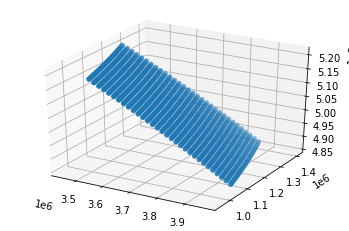

In [7]:
plotGlobe(xyz_list)

In [8]:
tops = filter_only_tops(xyz_list)

100%|██████████| 961/961 [00:20<00:00, 47.49it/s]


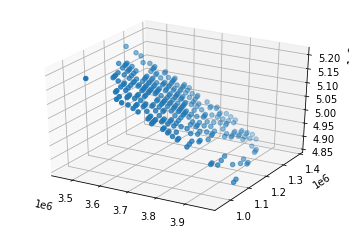

In [9]:
plotGlobe(tops)

In [0]:
save_results_to_local_file(tops, '/content/drive/My Drive/Colab Notebooks/calculate_tops/result.json')